In [2]:
import networkx as nx
import pandas as pd
from pyvis.network import Network
from networkx.algorithms import community
import matplotlib.pyplot as plt
import random
import math

def get_node_num_from_title(net, title):
    for num, node in enumerate(net.nodes):
        if node == title:
            return num
    return None

def assign_coordinates_with_leader(community):
    if not len(community)>5:
        return {}
    if not community:
        return {}

    leader = community[0]
    leader_coordinates = {'x': random.uniform(-1000, 1000), 'y': random.uniform(-1000, 1000)}
    coordinates = {leader: leader_coordinates}

    num_nodes = len(community)
    leader_distance = 5000 
    member_distance = 50  

    for i in range(1, num_nodes):
        angle = i * (2 * math.pi / (num_nodes - 1))
        x = leader_coordinates['x'] + leader_distance * math.cos(angle)
        y = leader_coordinates['y'] + leader_distance * math.sin(angle)
        node = community[i]
        coordinates[node] = {'x': x, 'y': y}

    for i in range(1, num_nodes):
        for j in range(i + 1, num_nodes):
            node_i = community[i]
            node_j = community[j]
            angle = random.uniform(0, 2 * math.pi)
            x_offset = member_distance * math.cos(angle)
            y_offset = member_distance * math.sin(angle)
            coordinates[node_i]['x'] += x_offset
            coordinates[node_i]['y'] += y_offset
            coordinates[node_j]['x'] -= x_offset
            coordinates[node_j]['y'] -= y_offset

    return coordinates


random.seed(42)
data = pd.read_csv('data/book1.csv')
G = nx.Graph()

for index, row in data.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['weight'])
    
communities = list(community.greedy_modularity_communities(G, weight='weight'))
betweenness_centrality = nx.betweenness_centrality(G)
pagerank_centrality = nx.pagerank(G, weight='weight')


for community_id, community in enumerate(communities):
    sorted_nodes = sorted(community, key=lambda node: pagerank_centrality[node], reverse=True)
    node_coordinates = assign_coordinates_with_leader(sorted_nodes)

color_list = ["orange","red","blue","#97c2fc","purple","pink","yellow"]

pyvis_network = Network(height="1000px",width="100%",filter_menu=True,select_menu=True,cdn_resources='remote')

for node in G.nodes():
    size = 1000 * pagerank_centrality[node]
    if node in node_coordinates:
        x, y = node_coordinates[node]["x"], node_coordinates[node]["y"]
        pyvis_network.add_node(node, size=size, label=node, fixed=True, x=x, y=y)
    else:
        pyvis_network.add_node(node, size=1000 * pagerank_centrality[node],label=node)
    
    
for n in pyvis_network.nodes:
    n["font"]={"size":27 + int(betweenness_centrality.get(n["label"])*355)}

for edge in G.edges():
    pyvis_network.add_edge(edge[0], edge[1], width=0.1 * G[edge[0]][edge[1]]['weight'])

pyvis_network.force_atlas_2based(central_gravity=0.02,spring_length=120,spring_strength=0.115,damping=1)


node_colors = {node: i for i, com in enumerate(communities) for node in com}

for node, color_index in node_colors.items():
    pyvis_network.nodes[get_node_num_from_title(G,node)]['color'] = color_list[color_index]

pyvis_network.show_buttons(filter_=["physics","edges"])
pyvis_network.show("graph.html", notebook=False)


graph.html


In [8]:
print("Node Sayısı:", len(G.nodes()))
print("Edge Sayısı:", len(G.edges()))

Node Sayısı: 187
Edge Sayısı: 684


In [4]:
diameter = nx.diameter(G)
print("Grafın Çapı:", diameter)


Grafın Çapı: 7


In [7]:
average_path_length = nx.average_shortest_path_length(G, weight='weight')
print(average_path_length)
average_path_length = nx.average_shortest_path_length(G)
print(average_path_length)

14.106146857570007
2.9124259674544306


In [13]:
density = nx.density(G)
print("Ağırlıksız Ağ Yoğunluğu",density)

Ağırlıksız Ağ Yoğunluğu 0.03933068828704502


In [12]:
total_weighted_edges = sum([G[u][v]['weight'] for u, v in G.edges])
possible_weighted_edges = len(G) * (len(G) - 1) / 2
weighted_density = total_weighted_edges / possible_weighted_edges

print("Ağırlıklı Ağ Yoğunluğu:", weighted_density)

Ağırlıklı Ağ Yoğunluğu: 0.4235524121672129


In [22]:
clustering_coefficient = nx.average_clustering(G)
print("Ağırlıksız kümelenme katsayısı",clustering_coefficient)
clustering_coefficient = nx.average_clustering(G, weight='weight')
print("Ağırlıklı kümelenme katsayısı",clustering_coefficient)

Ağırlıksız kümelenme katsayısı 0.5121189412047715
Ağırlıklı kümelenme katsayısı 0.016342288728068147


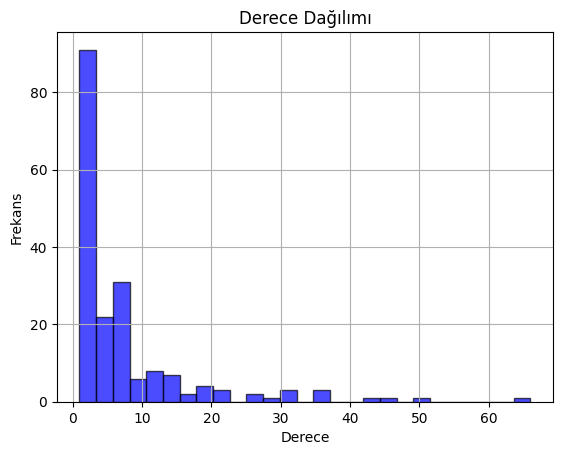

In [27]:
degree_sequence = [degree for node, degree in G.degree()]

plt.hist(degree_sequence, bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Derece Dağılımı')
plt.xlabel('Derece')
plt.ylabel('Frekans')
plt.grid(True)
plt.show()


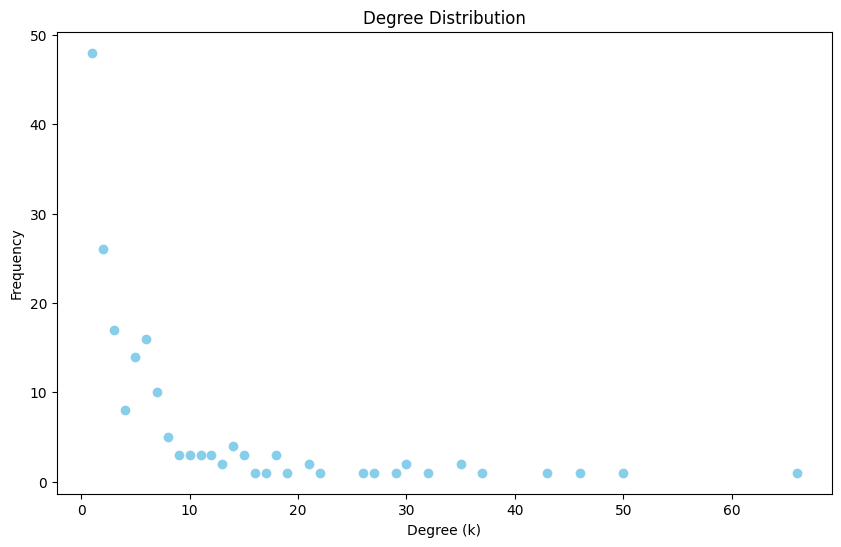

In [28]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_counts = pd.Series(degree_sequence).value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.scatter(degree_counts.index, degree_counts, marker='o', color='skyblue')
plt.title('Degree Distribution')
plt.xlabel('Degree (k)')
plt.ylabel('Frequency')
plt.show()


Derece Merkeziliği DataFrame:
                Node  Degree Centrality
0       Eddard-Stark           0.354839
1   Robert-Baratheon           0.268817
2   Tyrion-Lannister           0.247312
3      Catelyn-Stark           0.231183
4           Jon-Snow           0.198925
5         Robb-Stark           0.188172
6        Sansa-Stark           0.188172
7         Bran-Stark           0.172043
8   Cersei-Lannister           0.161290
9  Joffrey-Baratheon           0.161290


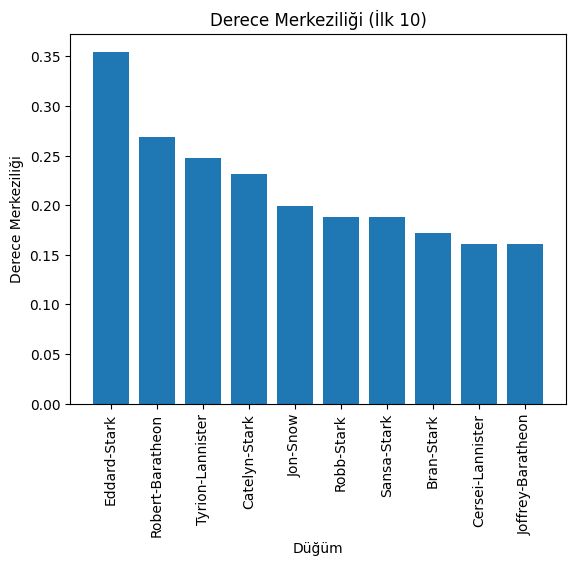

In [32]:
degree_centrality = nx.degree_centrality(G)

sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

df_degree_centrality = pd.DataFrame(sorted_degree_centrality, columns=['Node', 'Degree Centrality'])

print("Derece Merkeziliği DataFrame:")
print(df_degree_centrality.head(10))

plt.bar(df_degree_centrality['Node'][:10], df_degree_centrality['Degree Centrality'][:10])
plt.title('Derece Merkeziliği (İlk 10)')
plt.xlabel('Düğüm')
plt.ylabel('Derece Merkeziliği')
plt.xticks(rotation=90)
plt.show()

İlk 10 Arasındalık Merkeziliği:
                 Node  Betweenness Centrality
0        Eddard-Stark                0.269604
1    Robert-Baratheon                0.214030
2    Tyrion-Lannister                0.190212
3            Jon-Snow                0.171581
4       Catelyn-Stark                0.151395
5  Daenerys-Targaryen                0.086270
6          Robb-Stark                0.072984
7               Drogo                0.064812
8          Bran-Stark                0.055800
9         Sansa-Stark                0.037145


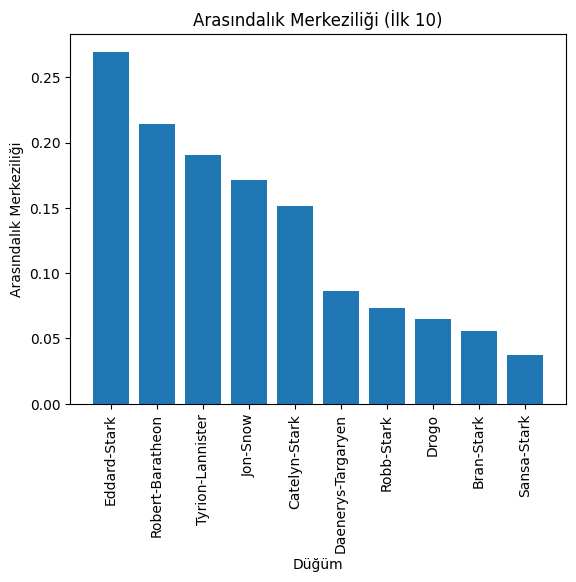

In [39]:
betweenness_centrality = nx.betweenness_centrality(G)

sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

df_betweenness_centrality = pd.DataFrame(sorted_betweenness_centrality, columns=['Node', 'Betweenness Centrality'])

print("İlk 10 Arasındalık Merkeziliği:")
print(df_betweenness_centrality.head(10))

plt.bar(df_betweenness_centrality['Node'][:10], df_betweenness_centrality['Betweenness Centrality'][:10])
plt.title('Arasındalık Merkeziliği (İlk 10)')
plt.xlabel('Düğüm')
plt.ylabel('Arasındalık Merkeziliği')
plt.xticks(rotation=90)
plt.show()

İlk 10 Yakınsaklık Merkeziliği:
                Node  Closeness Centrality
0       Eddard-Stark              0.563636
1   Robert-Baratheon              0.545455
2   Tyrion-Lannister              0.510989
3      Catelyn-Stark              0.505435
4         Robb-Stark              0.497326
5           Jon-Snow              0.493369
6        Sansa-Stark              0.489474
7         Bran-Stark              0.486911
8   Cersei-Lannister              0.484375
9  Joffrey-Baratheon              0.480620


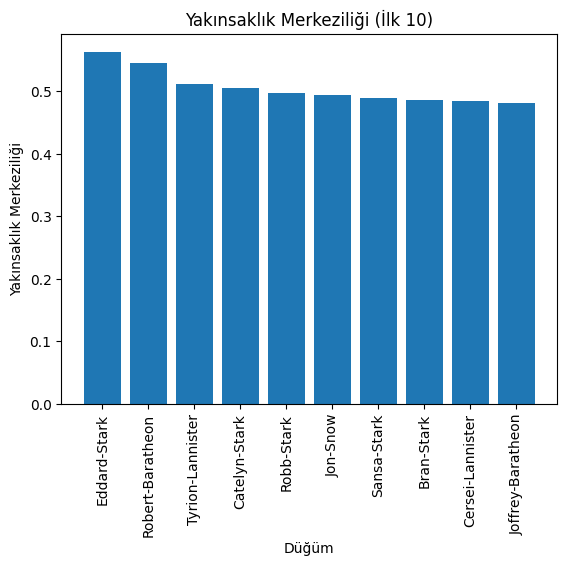

In [40]:
closeness_centrality = nx.closeness_centrality(G)

sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

df_closeness_centrality = pd.DataFrame(sorted_closeness_centrality, columns=['Node', 'Closeness Centrality'])

print("İlk 10 Yakınsaklık Merkeziliği:")
print(df_closeness_centrality.head(10))

plt.bar(df_closeness_centrality['Node'][:10], df_closeness_centrality['Closeness Centrality'][:10])
plt.title('Yakınsaklık Merkeziliği (İlk 10)')
plt.xlabel('Düğüm')
plt.ylabel('Yakınsaklık Merkeziliği')
plt.xticks(rotation=90)
plt.show()

İlk 10 PageRank:
                 Node  PageRank
0        Eddard-Stark  0.072362
1    Robert-Baratheon  0.048494
2            Jon-Snow  0.047708
3    Tyrion-Lannister  0.043676
4       Catelyn-Stark  0.034667
5          Bran-Stark  0.029770
6          Robb-Stark  0.029214
7  Daenerys-Targaryen  0.027099
8         Sansa-Stark  0.026945
9    Cersei-Lannister  0.021620


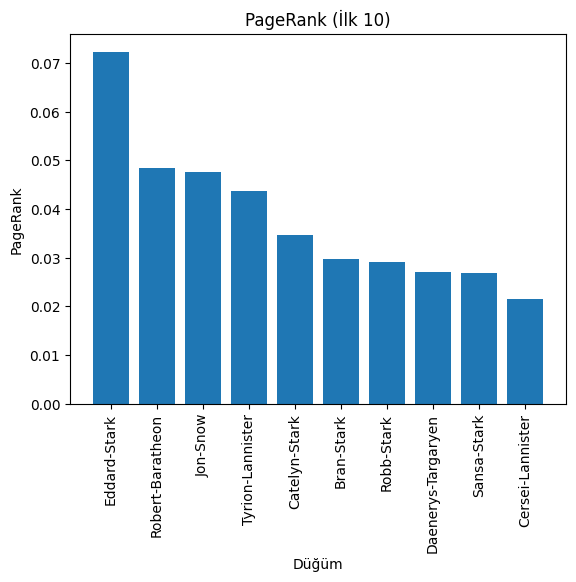

In [48]:
pagerank_centrality = nx.pagerank(G,weight="weight")

sorted_pagerank_centrality = sorted(pagerank_centrality.items(), key=lambda x: x[1], reverse=True)

df_pagerank_centrality = pd.DataFrame(sorted_pagerank_centrality, columns=['Node', 'PageRank'])

print("İlk 10 PageRank:")
print(df_pagerank_centrality.head(10))

plt.bar(df_pagerank_centrality['Node'][:10], df_pagerank_centrality['PageRank'][:10])
plt.title('PageRank (İlk 10)')
plt.xlabel('Düğüm')
plt.ylabel('PageRank')
plt.xticks(rotation=90)
plt.show()

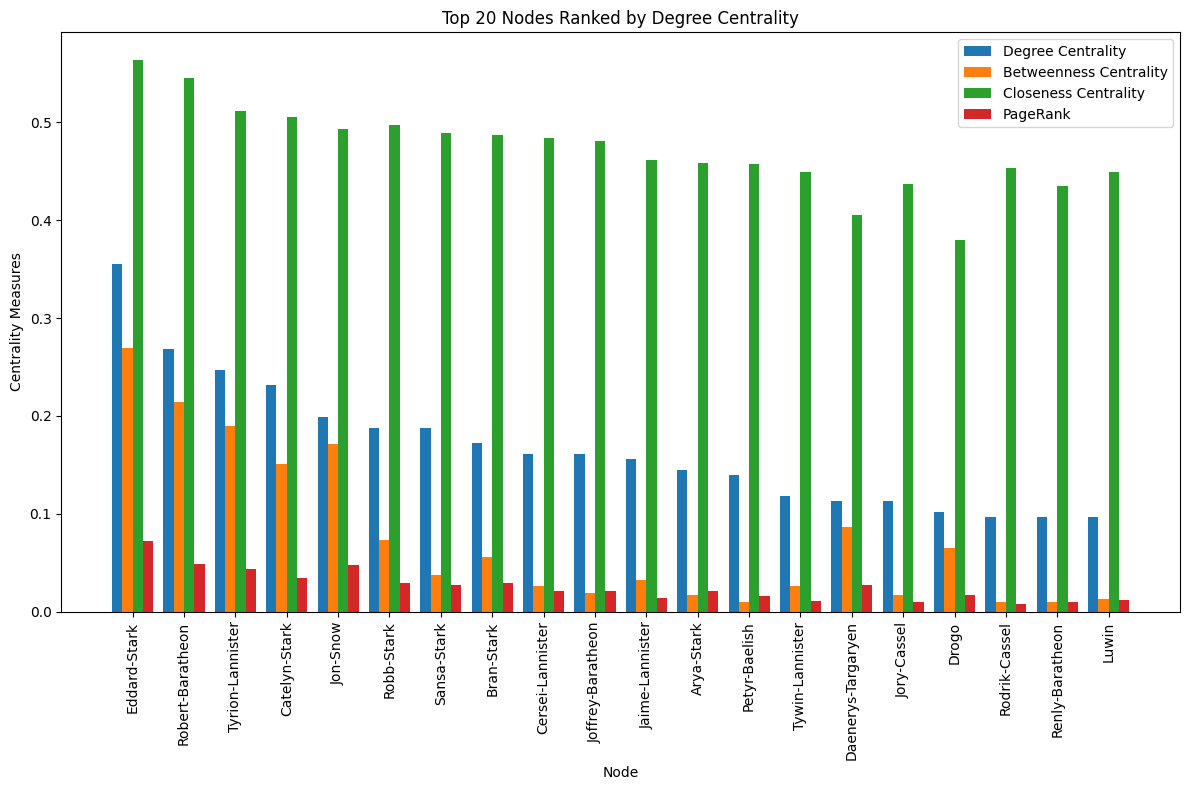

In [57]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
pagerank_centrality = nx.pagerank(G, weight='weight')

nodes = list(G.nodes())

df_centrality = pd.DataFrame({
    'Node': nodes,
    'Degree Centrality': [degree_centrality[node] for node in nodes],
    'Betweenness Centrality': [betweenness_centrality[node] for node in nodes],
    'Closeness Centrality': [closeness_centrality[node] for node in nodes],
    'PageRank Centrality': [pagerank_centrality[node] for node in nodes]
})

df_centrality = df_centrality.sort_values(by='Degree Centrality', ascending=False)

df_centrality_subset = df_centrality.head(20)

plt.figure(figsize=(12, 8))

bar_width = 0.2
index = range(len(df_centrality_subset['Node']))

plt.bar(index, df_centrality_subset['Degree Centrality'], width=bar_width, label='Degree Centrality')
plt.bar([i + bar_width for i in index], df_centrality_subset['Betweenness Centrality'], width=bar_width, label='Betweenness Centrality')
plt.bar([i + 2 * bar_width for i in index], df_centrality_subset['Closeness Centrality'], width=bar_width, label='Closeness Centrality')
plt.bar([i + 3 * bar_width for i in index], df_centrality_subset['PageRank Centrality'], width=bar_width, label='PageRank')

plt.title('Top 20 Nodes Ranked by Degree Centrality')
plt.xlabel('Node')
plt.ylabel('Centrality Measures')
plt.xticks([i + 1.5 * bar_width for i in index], df_centrality_subset['Node'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

Top 5 Characters Most Similar to Tyrion-Lannister:
Catelyn-Stark and Tyrion-Lannister - Jaccard Similarity: 0.36923076923076925
Bran-Stark and Tyrion-Lannister - Jaccard Similarity: 0.3220338983050847
Tyrion-Lannister and Jaime-Lannister - Jaccard Similarity: 0.3157894736842105
Robb-Stark and Tyrion-Lannister - Jaccard Similarity: 0.265625
Tyrion-Lannister and Rodrik-Cassel - Jaccard Similarity: 0.2549019607843137


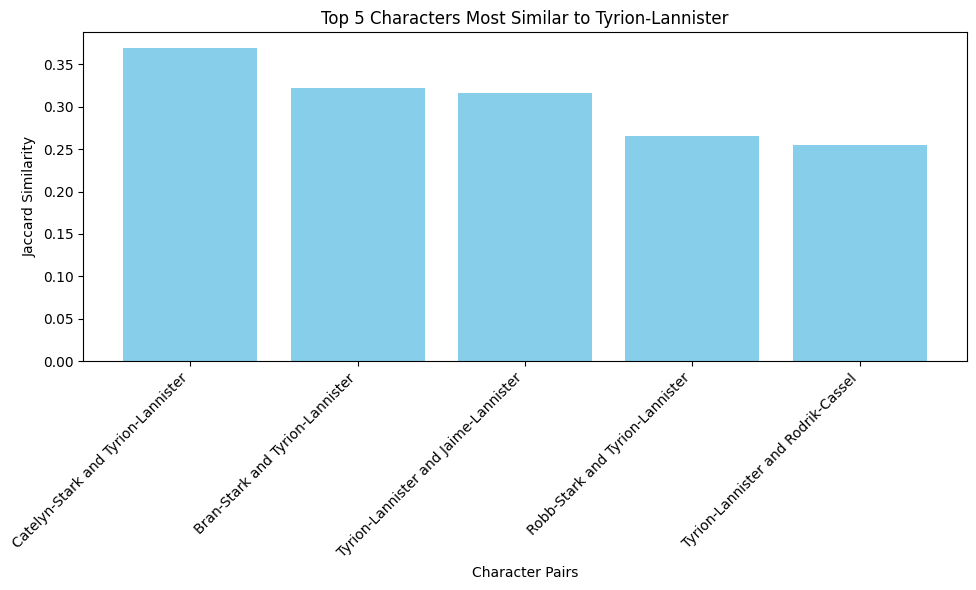

In [90]:
def find_most_similar(character, similarities):
    similar_characters = [(pair[0], pair[1]) for pair, similarity in similarities.items() if character in pair]
    similar_characters.sort(key=lambda x: similarities[x], reverse=True)
    return similar_characters[:5]

target_character = 'Tyrion-Lannister'

most_similar_to_target = find_most_similar(target_character, similarities)

print(f"Top 5 Characters Most Similar to {target_character}:")
for pair in most_similar_to_target:
    print(f"{pair[0]} and {pair[1]} - Jaccard Similarity: {similarities[pair]}")

import matplotlib.pyplot as plt

characters = [f"{pair[0]} and {pair[1]}" for pair in most_similar_to_target]
similarities_values = [similarities[pair] for pair in most_similar_to_target]

plt.figure(figsize=(10, 6))
plt.bar(characters, similarities_values, color='skyblue')
plt.xlabel('Character Pairs')
plt.ylabel('Jaccard Similarity')
plt.title(f"Top 5 Characters Most Similar to {target_character}")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


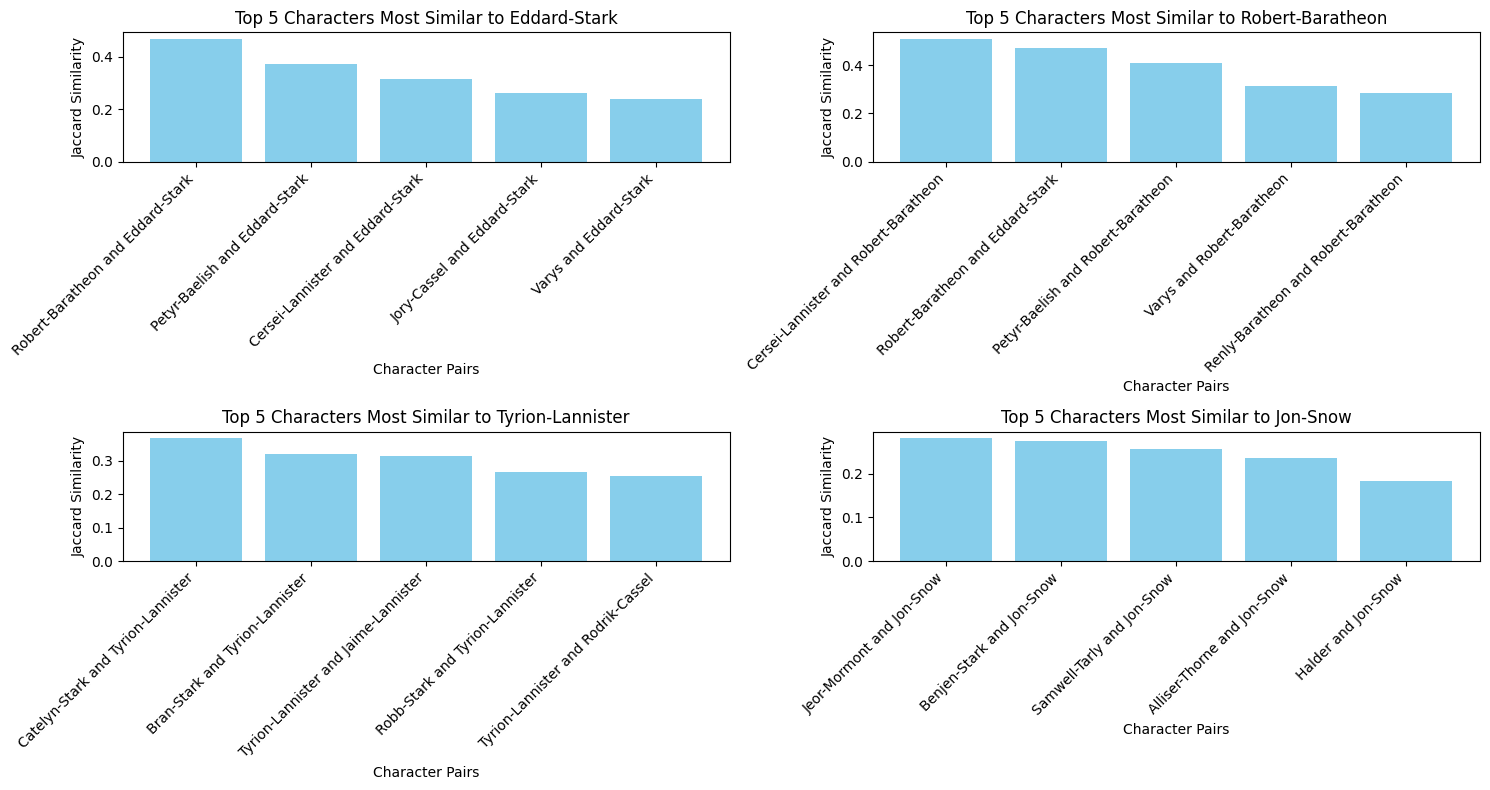

In [89]:
def find_most_similar(character, similarities):
    similar_characters = [(pair[0], pair[1]) for pair, similarity in similarities.items() if character in pair]
    similar_characters.sort(key=lambda x: similarities[x], reverse=True)
    return similar_characters[:5]

target_characters = ['Eddard-Stark', 'Robert-Baratheon', 'Tyrion-Lannister', 'Jon-Snow']

most_similar_dict = {}

for target_character in target_characters:
    most_similar_to_target = find_most_similar(target_character, similarities)
    most_similar_dict[target_character] = most_similar_to_target

plt.figure(figsize=(15, 8))

for i, target_character in enumerate(target_characters):
    characters = [f"{pair[0]} and {pair[1]}" for pair in most_similar_dict[target_character]]
    similarities_values = [similarities[pair] for pair in most_similar_dict[target_character]]
    
    plt.subplot(2, 2, i + 1)
    plt.bar(characters, similarities_values, color='skyblue')
    plt.xlabel('Character Pairs')
    plt.ylabel('Jaccard Similarity')
    plt.title(f"Top 5 Characters Most Similar to {target_character}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plt.show()
